<a href="https://colab.research.google.com/github/PGPradhan/Sales-Forecasting/blob/sales-story/Sales_Forcasting_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [54]:
df = pd.read_csv('/content/Forecasting.csv')
df

,date,total_quantity
0,12-10-2016,1.0
1,12-09-2016,1.0
2,13-09-2016,1.0
3,23-09-2016,4.0
4,23-09-2016,5.0
...,...,...
999,NaN,NaN
1000,NaN,NaN
1001,NaN,NaN
1002,NaN,NaN


In [55]:

df.isnull().sum()

date              12
total_quantity    11
dtype: int64

In [60]:
import pandas as pd
import numpy as np

# Assuming df is your DataFrame with a 'date' column
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')  # Convert date column to datetime object

# Create Date-related Features to be used for EDA and Supervised ML: Regression
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['weekday'] = np.where(df.weekday == 0, 7, df.weekday)

# Split the series to predict the last 3 months of 2017
temp_df = df.set_index('date')
train_df = temp_df.loc[:'2017-09-30'].reset_index(drop=False)  # Adjust the date range as per your data
test_df = temp_df.loc['2017-10-01':].reset_index(drop=False)  # Adjust the date range as per your data

train_df.head()


,date,total_quantity,year,month,day,weekday
0,2016-10-12,1.0,2016.0,10.0,12.0,2.0
1,2016-09-12,1.0,2016.0,9.0,12.0,7.0
2,2016-09-13,1.0,2016.0,9.0,13.0,1.0
3,2016-09-23,4.0,2016.0,9.0,23.0,4.0
4,2016-09-23,5.0,2016.0,9.0,23.0,4.0


In [61]:
test_df.head()

,date,total_quantity,year,month,day,weekday
0,2017-11-14,1.0,2017.0,11.0,14.0,1.0
1,2017-11-19,1.0,2017.0,11.0,19.0,6.0
2,2017-11-25,1.0,2017.0,11.0,25.0,5.0
3,2017-11-26,1.0,2017.0,11.0,26.0,6.0
4,2017-11-25,2.0,2017.0,11.0,25.0,5.0


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
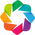

:BoxWhisker   [weekday]   (total_quantity)

In [62]:
import pandas as pd
import hvplot.pandas
import holoviews as hv

# Assuming df is your DataFrame with 'weekday' and 'total_quantity' columns
plot = df.hvplot.box(y='total_quantity', by='weekday', title='Weekly sales distribution', xlabel='Weekday', ylabel='Total Quantity', ylim=(0, 10))
hv.extension('bokeh')  # Use Bokeh for plotting
plot



In [63]:
pip install hvplot

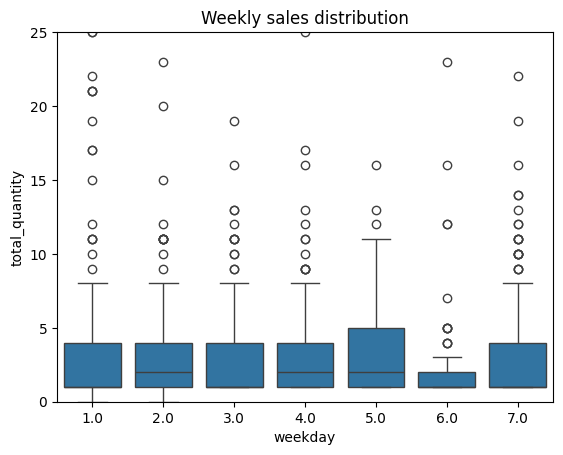

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

plot = sns.boxplot(x='weekday', y='total_quantity', data=df)
plot.set(title='Weekly sales distribution')
plot.set_ylim(0, 25)
plt.show()


Inference: The average number of sales increases over the week, is maximum on Friday (5), and takes a sharp fall on Saturday (6)

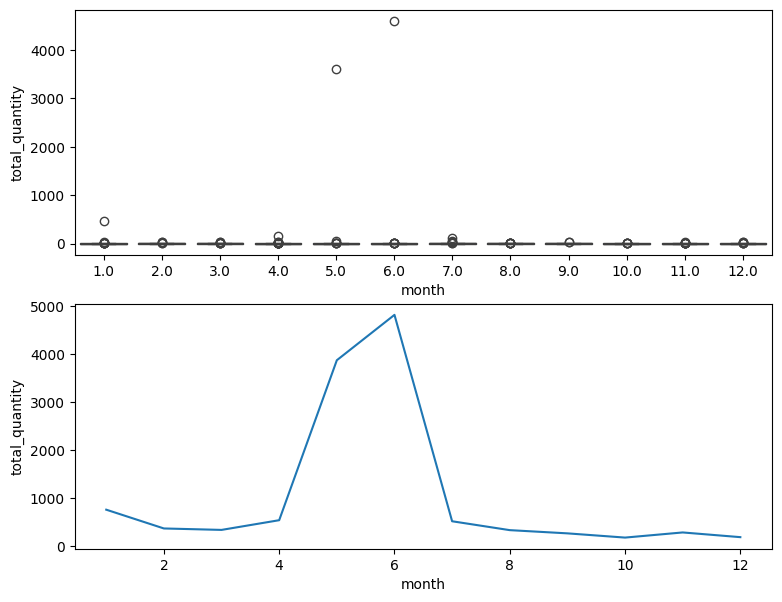

In [65]:
monthly_agg = df.groupby('month')['total_quantity'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='month', y='total_quantity', data=df, ax=axs[0])
_ = sn.lineplot(x='month', y='total_quantity', data=monthly_agg, ax=axs[1])

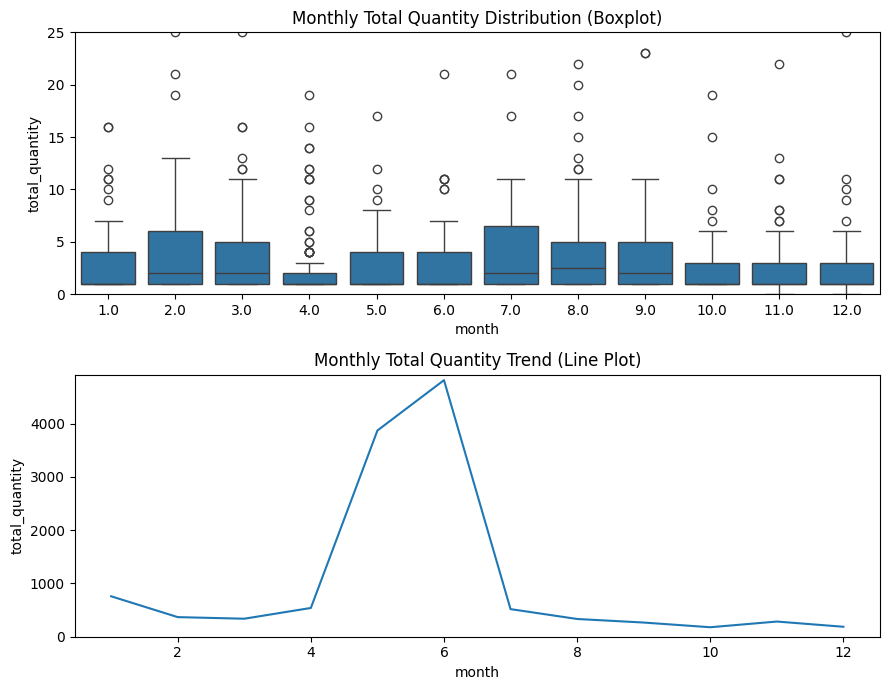

In [66]:
monthly_agg = df.groupby('month')['total_quantity'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))

# Boxplot
ax1 = sn.boxplot(x='month', y='total_quantity', data=df, ax=axs[0])
ax1.set_title('Monthly Total Quantity Distribution (Boxplot)')
ax1.set_ylim(0, 25)  # Set y-axis limits for boxplot

# Line plot
ax2 = sn.lineplot(x='month', y='total_quantity', data=monthly_agg, ax=axs[1])
ax2.set_title('Monthly Total Quantity Trend (Line Plot)')
ax2.set_ylim(0, monthly_agg['total_quantity'].max() + 100)  # Set y-axis limits for line plot

plt.tight_layout()
plt.show()


Inference: The number of sales gradually ascends in the first half of the year starting April (4), peaks in June (6), and then descends, before slightly increasing in November (11) and then dropping again in December (12).

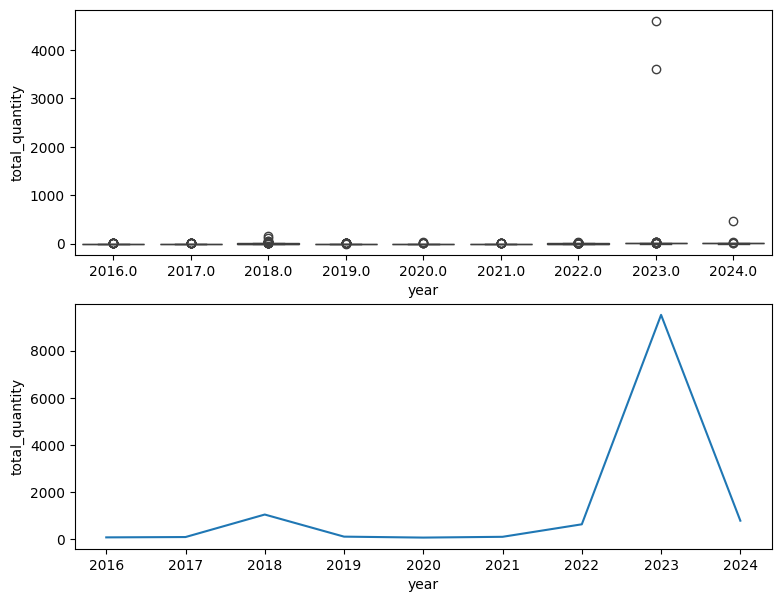

In [67]:
yearly_agg = df.groupby('year')['total_quantity'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='year', y='total_quantity', data=df, ax=axs[0])
_ = sn.lineplot(x='year', y='total_quantity', data=yearly_agg, ax=axs[1])

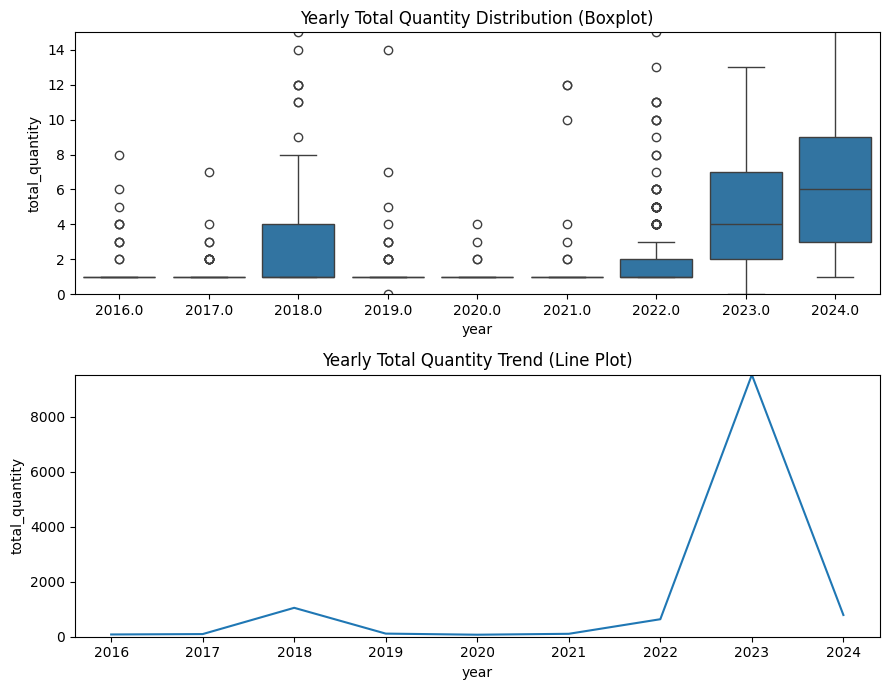

In [68]:
yearly_agg = df.groupby('year')['total_quantity'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))

# Boxplot
ax1 = sn.boxplot(x='year', y='total_quantity', data=df, ax=axs[0])
ax1.set_title('Yearly Total Quantity Distribution (Boxplot)')
ax1.set_ylim(0, 15)  # Set y-axis limits for boxplot

# Line plot
ax2 = sn.lineplot(x='year', y='total_quantity', data=yearly_agg, ax=axs[1])
ax2.set_title('Yearly Total Quantity Trend (Line Plot)')
ax2.set_ylim(0, yearly_agg['total_quantity'].max() )  # Set y-axis limits for line plot

plt.tight_layout()
plt.show()


It is been increased slightly in the year 2018. It had a flat line after that (Supposingly because of Covid). Then It experienced a linearly exponential growth

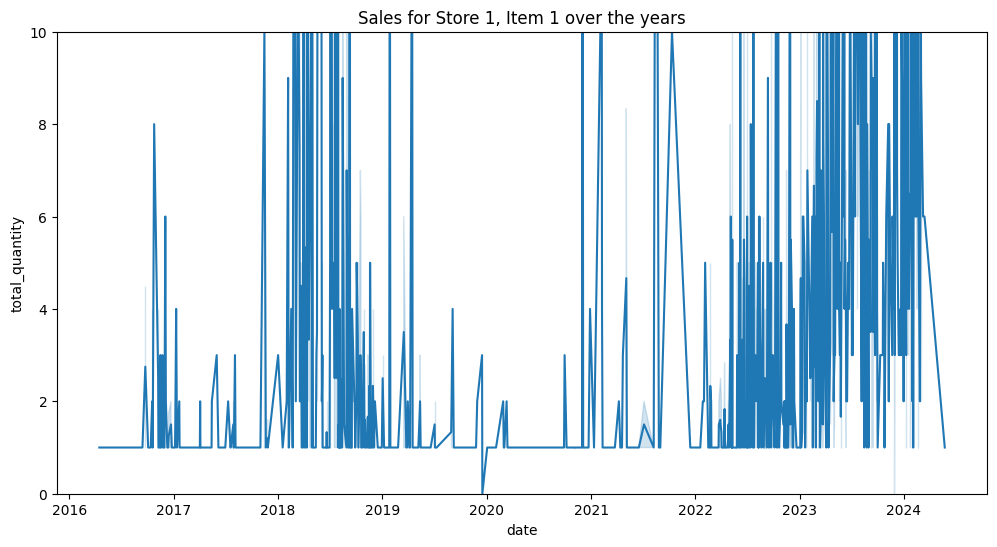

In [69]:
plt.figure(figsize=(12, 6))
# Line plot

plot = sn.lineplot(x='date', y='total_quantity', data=df)
_ = plot.set(title='Sales for Store 1, Item 1 over the years')
plot.set_ylim(0, 10)

plt.show()


In [ ]:
import pandas as pd

# Convert 'date' column to datetime format
X_train['date'] = pd.to_datetime(X_train['date'])

# Extract year, month, and day as numerical features
X_train['year'] = X_train['date'].dt.year
X_train['month'] = X_train['date'].dt.month
X_train['day'] = X_train['date'].dt.day

# Drop the original 'date' column
# X_train = X_train.drop(columns=['date'])


KeyError: 'date'

In [ ]:
X_train = X_train.drop(columns=['date'])


KeyError: "['date'] not found in axis"

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression